# Chapter 7: Power user options

midap-tools has been designed so it allows you to use your custom methods for data analysis methods.

This currently includes:
- data transforms
    - on a single data columns (pandas Series)
    - on a data frames (pandas Dataframe)
- growth calculations
- density calculations

## custom data transforms (single column data)
a fairly straight forward method for power users is the data transform
the function by default performs a log transformation on a given column, however it can also accept a custom function and additional keywords as arguments

lets see how we could use this to do our own transform

In [47]:
from fluid_experiment.fluid_experiment import FluidExperiment

PATH = "../../data/midap-tools_example"
experiment = FluidExperiment(PATH, name= "example_experiment")
experiment.load_metadata_template()
print(experiment)

Loading sample at position pos1 for color channel YFP
Loading sample at position pos1 for color channel CFP
Loading sample at position pos2 for color channel YFP
Loading sample at position pos2 for color channel CFP
Loading sample at position pos3 for color channel YFP
Loading sample at position pos3 for color channel CFP
Loading sample at position pos4 for color channel YFP
Loading sample at position pos4 for color channel CFP
Loading sample at position pos5 for color channel YFP
Loading sample at position pos5 for color channel CFP
Loading sample at position pos6 for color channel YFP
Loading sample at position pos6 for color channel CFP
Successfully loaded data with consistent number of frames: 143
FluidExperiment with name: example_experiment
Path: ../../data/midap-tools_example
6 positions: pos1, pos2, pos3, pos4, pos5, pos6
2 color channels: YFP, CFP
length of experiment is consistent: 143
experiment has consistent headers: Unnamed: 0, globalID, frame, labelID, trackID, lineageID

***

to start with, lets assume we want to create a function that limits a columns value to lie between two ranges.

lets say we see that our area is variable and does not make logical sense for any value < 50 and > 1000
so these we want to cap to a minimum and maximum.

we start by defining this function.
then we supply it to the transform operation, including its own arguments (upper and lower bounds)

FluidExperiment with name: example_experiment
Path: ../../data/midap-tools_example
6 positions: pos1, pos2, pos3, pos4, pos5, pos6
2 color channels: YFP, CFP
length of experiment is consistent: 143
experiment has consistent headers: Unnamed: 0, globalID, frame, labelID, trackID, lineageID, trackID_d1, trackID_d2, split, trackID_mother, first_frame, last_frame, area, edges_min_row, edges_min_col, edges_max_row, edges_max_col, intensity_max, intensity_mean, intensity_min, minor_axis_length, major_axis_length, x, y, area_capped
Experiment has metadata:
         position   group          experiment  device_channel
position                                                     
pos1         pos1  Group1  example_experiment               1
pos2         pos2  Group1  example_experiment               2
pos3         pos3  Group1  example_experiment               3
pos4         pos4  Group2  example_experiment               1
pos5         pos5  Group2  example_experiment               2
pos6      

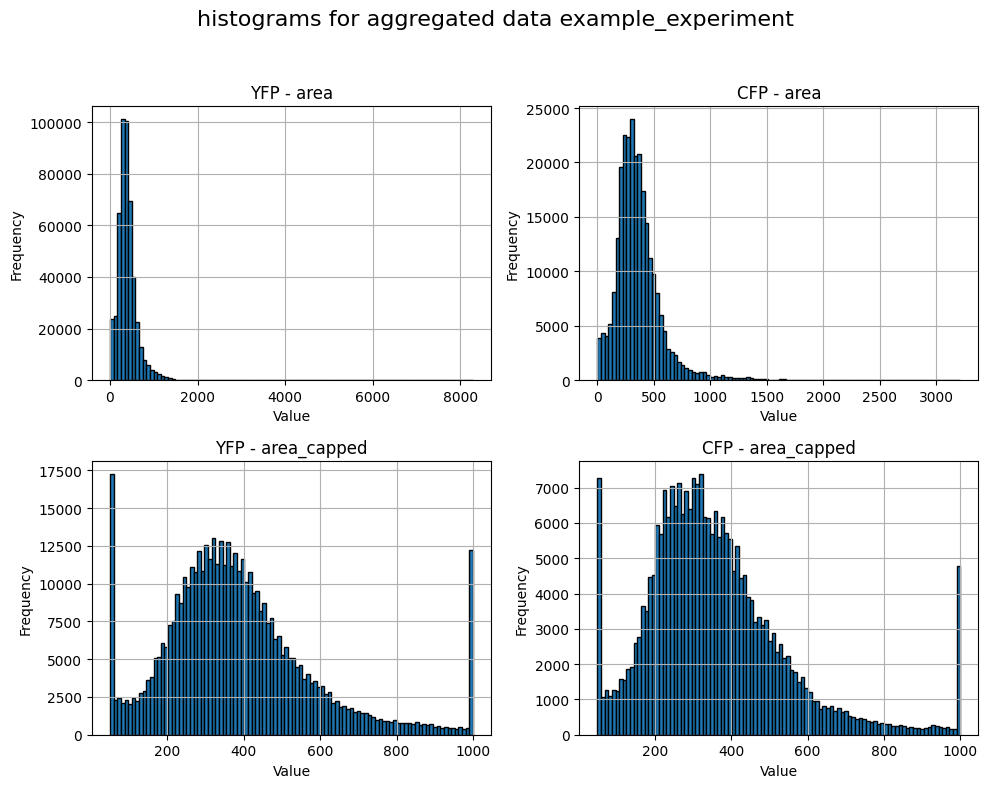

In [48]:
import pandas as pd

def cap_data(data: pd.Series, lower: float, upper: float) -> pd.Series:
    """ limits a pd.Series to lie within upper and lower limits
    Args:
        data (pd.Series): the data to cap
        upper (float): the upper limit
        lower (float): the lower limit
    Returns:
        pd.Series: the capped data
    """
    data = data.copy()
    data[data > upper] = upper
    data[data < lower] = lower
    return data

experiment.calculate_transform_data(column="area", postfix="_capped", custom_function= cap_data, lower = 50, upper = 1000)

print(experiment)
experiment.plot_qc_histograms(["area","area_capped"],group_by="experiment")

***

**Note:** our custom function relies on two new arguments, upper bound (float) and lower bound (float). We need to pass these along when we call `calculate_transform_data` with the custom function `cap_data`. It is advised to always pass these along with the correct keyword:

don't try:
```
experiment.calculate_transform_data(column="area", postfix="_capped", custom_function= cap_data, 50, 1000)
```
alway do:
```
experiment.calculate_transform_data(column="area", postfix="_capped", custom_function= cap_data, lower = 50, upper = 1000)
```

## custom data frame operations

having the ability to calculate a new column base on its own values can be usefull, however sometimes we may want to combine data from two or more columns

lets show this with an example where we want to calculate the distance to the center of the image for each cell

to do this we have to:
- figure out where the center of the image is 
- calculate the eucledian distance for each cell
- save this as new column

we start by creating a custom function that takes a pandas dataframe and the key of the x and y column and returns a modified pandas dataframe to which we added a `distance_to_center` column

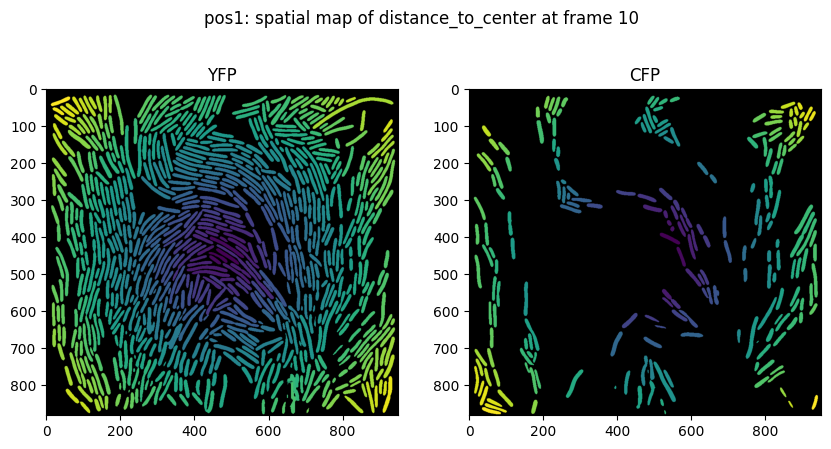

In [ ]:
def calculate_distance_center_hardcoded(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()
    center_x = data["x"].min() + (data["x"].max() - data["x"].min()) / 2
    center_y = data["y"].min() + (data["y"].max() - data["y"].min()) / 2
    data["distance_to_center"] = ((data["x"] - center_x) ** 2 + (data["y"] - center_y) ** 2) ** 0.5
    return data

***

we can no apply this function to the experiment by using the following command, and then we visualize the results on an example to ensure the function works as intended


In [ ]:
experiment.calculate_dataframe_operation(custom_function=calculate_distance_center_hardcoded)
experiment.plot_spatial_maps(frame=10, property_column="distance_to_center", positions="pos1")

***

**Note:** it is better practice to create more flexible functions in general. lets assume that we may want to re_normalize the x and y coordinates and now have the flexibility to call it with custom column keys. See the example below how we could create a function that is more versatile in useage

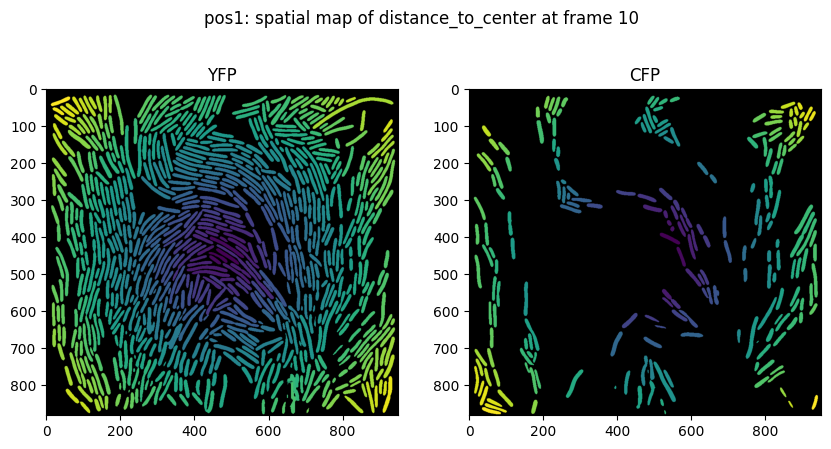

In [ ]:
def calculate_distance_center(data: pd.DataFrame, x_column: str, y_column: str) -> pd.DataFrame:
    """ for each row in a dataframe, calcualates the distance of x and y to the center
    Args:
        data (pd.DataFrame): the data to process
        x_column (str): column name for x coordinates
        y_column (str): column name for y coordinates
    Returns:
        pd.DataFrame: the original data with an additional column "distance_to_center" containing the distances
    """
    data = data.copy()
    center_x = data[x_column].min() + (data[x_column].max() - data[x_column].min()) / 2
    center_y = data[y_column].min() + (data[y_column].max() - data[y_column].min()) / 2
    data["distance_to_center"] = ((data[x_column] - center_x) ** 2 + (data[y_column] - center_y) ** 2) ** 0.5
    return data

***

now, when calling this function we have to be sure that we pass the required keywords along. here `x_column` and `y_column` need to be specified

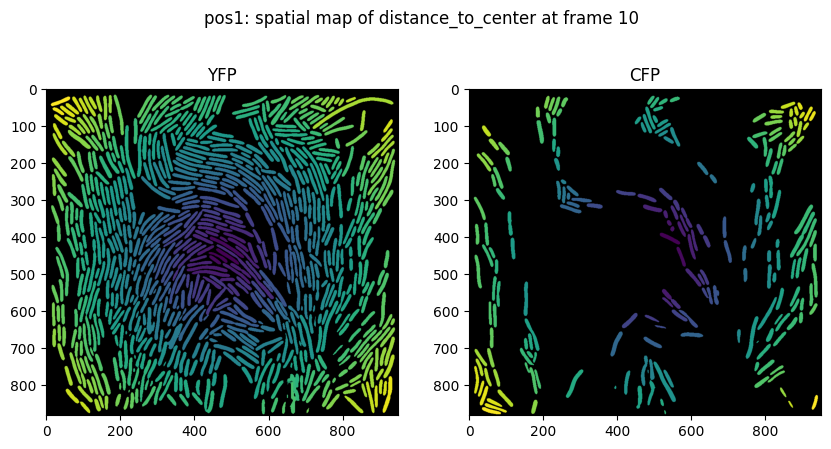

In [60]:
experiment.calculate_dataframe_operation(custom_function=calculate_distance_center,x_column = "x", y_column = "y")

experiment.plot_spatial_maps(frame=10, property_column="distance_to_center", positions="pos1")

***

the advantage is, now we have a more versatile function where we can specify which columns it should use for the operation

## custom growth rate calculation

calculation of growth rate can also be performed with a custom function.

the standard approach uses the function `calculate_growth_rate` from the file `src/analysis/growth_rate.py`

however, the same document has a more complex version that uses a linear fit to calculate the growth rate, and also produces an R2 score. While much slower, the added R2 square values may be used for some more advanced filtering operations by certain users.

to access it we can load it from this python document using the code bellow.

In [50]:
from analysis.growth_rate import calculate_growth_rate_r2

experiment.calculate_growth_rate(integration_window=5, id_column="trackID", value_column= "major_axis_length", custom_method=calculate_growth_rate_r2)
print(experiment)

Calculate growth rate for trackID measured with major_axis_length over an integration window of 5
FluidExperiment with name: example_experiment
Path: ../../data/midap-tools_example
6 positions: pos1, pos2, pos3, pos4, pos5, pos6
2 color channels: YFP, CFP
length of experiment is consistent: 143
experiment has consistent headers: Unnamed: 0, globalID, frame, labelID, trackID, lineageID, trackID_d1, trackID_d2, split, trackID_mother, first_frame, last_frame, area, edges_min_row, edges_min_col, edges_max_row, edges_max_col, intensity_max, intensity_mean, intensity_min, minor_axis_length, major_axis_length, x, y, area_capped, distance_to_center, growth_rate, growth_rsquared
Experiment has metadata:
         position   group          experiment  device_channel
position                                                     
pos1         pos1  Group1  example_experiment               1
pos2         pos2  Group1  example_experiment               2
pos3         pos3  Group1  example_experiment   

***

we note that this function now create a `growth_rsquared` column in addition to the `growth_rate` column

we can now visualize this r2 value in the entire experiment, and after filtering out only the initial 20 frames (where cells were growing)

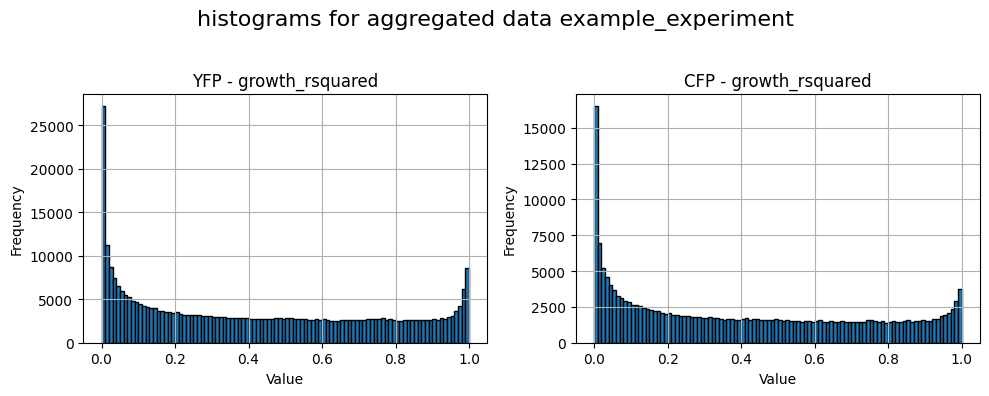

Filtering out frame with less than 0 occurences
Filtering out frame with min value None and max value 20
Filtering channel YFP at position pos1:
Filtering channel CFP at position pos1:
Filtering channel YFP at position pos2:
Filtering channel CFP at position pos2:
Filtering channel YFP at position pos3:
Filtering channel CFP at position pos3:
Filtering channel YFP at position pos4:
Filtering channel CFP at position pos4:
Filtering channel YFP at position pos5:
Filtering channel CFP at position pos5:
Filtering channel YFP at position pos6:
Filtering channel CFP at position pos6:


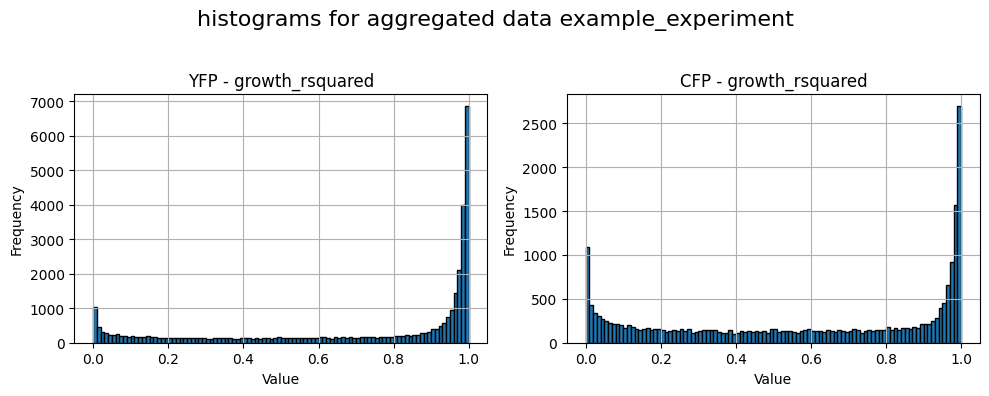

In [51]:
experiment.plot_qc_histograms("growth_rsquared", group_by="experiment")

experiment_filtered = FluidExperiment.from_copy(experiment)
experiment_filtered.filter_data("frame", max_value=20)
experiment_filtered.plot_qc_histograms("growth_rsquared", group_by="experiment")

We can apprechiate how using such an approach a power user can start building up his own function collection that he can use in conjecture with the FluidExperiment framework

the best practice to work with custom functions is to create a copy of the default method used for `calculate_growth_rate`, give it a new name (i.e `calculate_growth_rate_experimentX`) and save it in a custom python script (that could be saved in `src/analysis/custom_growth_rate.py`)

## Custom local neighborhood calculation

The last operation that can be called with a custom function is the calculation of the local neighborhood.

For this example, lets take the exisiting function `compute_neighborhood_segmentation` as found in `src/analysis/local_neighborhood.py`

This time we aim to adapt the entire function to our needs, so you can see the process

In [ ]:
import numpy as np

def compute_neighborhood_segmentation(data: dict, 
                                      masks, 
                                      neighborhood_prefix: str = "density_", 
                                      distance_threshold: int = 50,
                                      include_empty: bool = True):
    """
    Computes neighborhood segmentation densities for a set of target points within a given distance threshold.
    This function calculates the density of overlap between a circular region around each target point and a set of binary masks. 
    The result is added as new columns to the target DataFrame, with one column per mask.

    Parameters:
    -----------
    data : dict of pd.DataFrame
        A dictionary where keys are target identifiers and values are pandas DataFrames. 
        Each DataFrame must contain the following columns:
        - 'frame': The frame index (int).
        - 'x': The x-coordinate of the target point (float or int).
        - 'y': The y-coordinate of the target point (float or int).

    masks : dict of np.ndarray
        A dictionary where keys are source identifiers and values are 3D numpy arrays representing binary masks.
        Each mask has the shape (frames, height, width), where:
        - frames: The number of frames in the mask.
        - height: The height of the mask.
        - width: The width of the mask.

    neighborhood_prefix : str, optional
        A prefix for the column names added to the target DataFrames. Default is "density_".
        
    include_empty : bool, optional
        If True, the density is calculated as the ratio of the overlapping area to the total area of the circular region.

    distance_threshold : int, optional
        The rixeadius of the circular region (in pls) used to compute the neighborhood density. Default is 50.

    Returns:
    --------
    dict of pd.DataFrame
        The input `data` dictionary with updated DataFrames. Each DataFrame will have additional columns, 
        one for each mask in `masks`. The column names are prefixed with `neighborhood_prefix` followed by the mask key.

    Notes:
    ------
    - The function uses a circular mask to define the neighborhood region around each target point.
    - The density is calculated as the ratio of the overlapping area between the circular region and the binary mask 
      to the total area of the circular region.
    - If the circular region extends beyond the bounds of the mask, it is clipped to fit within the mask dimensions.
    """
    yy, xx = np.meshgrid(np.arange(-distance_threshold, distance_threshold + 1),
                         np.arange(-distance_threshold, distance_threshold + 1))
    circle_mask = (xx**2 + yy**2) <= distance_threshold**2
    dx, dy = circle_mask.shape

    for target_key, target_df in data.items():
        for source_key, mask in masks.items():
            densities = []

            for _, row in target_df.iterrows():
                frame = int(row['frame'])
                x = int(round(row['x']))
                y = int(round(row['y']))

                x0, y0 = x - dx // 2, y - dy // 2
                x1, y1 = x0 + dx, y0 + dy

                # Clip to bounds
                x0_clip, y0_clip = max(0, x0), max(0, y0)
                x1_clip, y1_clip = min(mask.shape[1], x1), min(mask.shape[2], y1)

                # Adjust circle mask slice to match the clipped region
                cx0, cy0 = x0_clip - x0, y0_clip - y0
                cx1, cy1 = cx0 + (x1_clip - x0_clip), cy0 + (y1_clip - y0_clip)
                circle_submask = circle_mask[cx0:cx1, cy0:cy1]

                region = mask[frame, x0_clip:x1_clip, y0_clip:y1_clip]
                if include_empty:
                    valid_area = circle_submask.sum()
                else:
                    # Sum over all masks for the denominator
                    total_overlap = 0
                    for other_mask in masks.values():
                        other_region = other_mask[frame, x0_clip:x1_clip, y0_clip:y1_clip]
                        total_overlap += np.logical_and(other_region, circle_submask).sum()
                    valid_area = total_overlap
                overlap = np.logical_and(region, circle_submask).sum()

                ratio = overlap / valid_area if valid_area > 0 else 0.0
                densities.append(ratio)

            colname = f'{neighborhood_prefix}{source_key}'
            target_df[colname] = densities

    return data

***

after reviewing this function, we may decide that we want to use a circle mask. instead we would like to have a rectangular mask, where we calculate densities using a narrow rectangle.
we therefore modify the first part of the function that defines the cirlce mask, and calculate a square mask instead

In [53]:
def compute_neighborhood_segmentation_rectangle(data: dict, 
                                      masks, 
                                      neighborhood_prefix: str = "density_", 
                                      distance_threshold: int = 50,
                                      include_empty: bool = True,
                                      height_ratio: float = 1.):
    """
    Computes neighborhood segmentation densities for a set of target points within a given distance threshold.
    This function calculates the density of overlap between a circular region around each target point and a set of binary masks. 
    The result is added as new columns to the target DataFrame, with one column per mask.

    Parameters:
    -----------
    data : dict of pd.DataFrame
        A dictionary where keys are target identifiers and values are pandas DataFrames. 
        Each DataFrame must contain the following columns:
        - 'frame': The frame index (int).
        - 'x': The x-coordinate of the target point (float or int).
        - 'y': The y-coordinate of the target point (float or int).

    masks : dict of np.ndarray
        A dictionary where keys are source identifiers and values are 3D numpy arrays representing binary masks.
        Each mask has the shape (frames, height, width), where:
        - frames: The number of frames in the mask.
        - height: The height of the mask.
        - width: The width of the mask.

    neighborhood_prefix : str, optional
        A prefix for the column names added to the target DataFrames. Default is "density_".
        
    include_empty : bool, optional
        If True, the density is calculated as the ratio of the overlapping area to the total area of the circular region.

    distance_threshold : int, optional
        The rixeadius of the circular region (in pls) used to compute the neighborhood density. Default is 50.

    Returns:
    --------
    dict of pd.DataFrame
        The input `data` dictionary with updated DataFrames. Each DataFrame will have additional columns, 
        one for each mask in `masks`. The column names are prefixed with `neighborhood_prefix` followed by the mask key.

    Notes:
    ------
    - The function uses a circular mask to define the neighborhood region around each target point.
    - The density is calculated as the ratio of the overlapping area between the circular region and the binary mask 
      to the total area of the circular region.
    - If the circular region extends beyond the bounds of the mask, it is clipped to fit within the mask dimensions.
    """
    distance_threshold_x = distance_threshold * height_ratio
    distance_threshold_y = distance_threshold
    _, xx = np.meshgrid(np.arange(-distance_threshold_y, distance_threshold_y + 1),
                        np.arange(-distance_threshold_x, distance_threshold_x + 1))
    rectangle_mask = np.ones_like(xx, dtype=bool)
    dx, dy = rectangle_mask.shape

    for target_key, target_df in data.items():
        for source_key, mask in masks.items():
            densities = []

            for _, row in target_df.iterrows():
                frame = int(row['frame'])
                x = int(round(row['x']))
                y = int(round(row['y']))

                x0, y0 = x - dx // 2, y - dy // 2
                x1, y1 = x0 + dx, y0 + dy

                # Clip to bounds
                x0_clip, y0_clip = max(0, x0), max(0, y0)
                x1_clip, y1_clip = min(mask.shape[1], x1), min(mask.shape[2], y1)

                # Adjust circle mask slice to match the clipped region
                cx0, cy0 = x0_clip - x0, y0_clip - y0
                cx1, cy1 = cx0 + (x1_clip - x0_clip), cy0 + (y1_clip - y0_clip)
                rectangle_submask = rectangle_mask[cx0:cx1, cy0:cy1]

                region = mask[frame, x0_clip:x1_clip, y0_clip:y1_clip]
                if include_empty:
                    valid_area = rectangle_submask.sum()
                else:
                    # Sum over all masks for the denominator
                    total_overlap = 0
                    for other_mask in masks.values():
                        other_region = other_mask[frame, x0_clip:x1_clip, y0_clip:y1_clip]
                        total_overlap += np.logical_and(other_region, rectangle_submask).sum()
                    valid_area = total_overlap
                overlap = np.logical_and(region, rectangle_submask).sum()

                ratio = overlap / valid_area if valid_area > 0 else 0.0
                densities.append(ratio)

            colname = f'{neighborhood_prefix}{source_key}'
            target_df[colname] = densities

    return data

***

we can now calculate the local density with this adapted function that uses a rectangular mask, and for which we can set the height to width ratio

in this case we use the modified method that considers density in a 400 by 20 rectangle around each cell

In [54]:
experiment.calculate_local_neighborhood(distance_threshold = 200, custom_function = compute_neighborhood_segmentation_rectangle, height_ratio = 0.05)

Calculating neighborhoods of all channels in a radius of 200 px
Calculate neighborhoods for position pos1
Calculate neighborhoods for position pos2
Calculate neighborhoods for position pos3
Calculate neighborhoods for position pos4
Calculate neighborhoods for position pos5
Calculate neighborhoods for position pos6


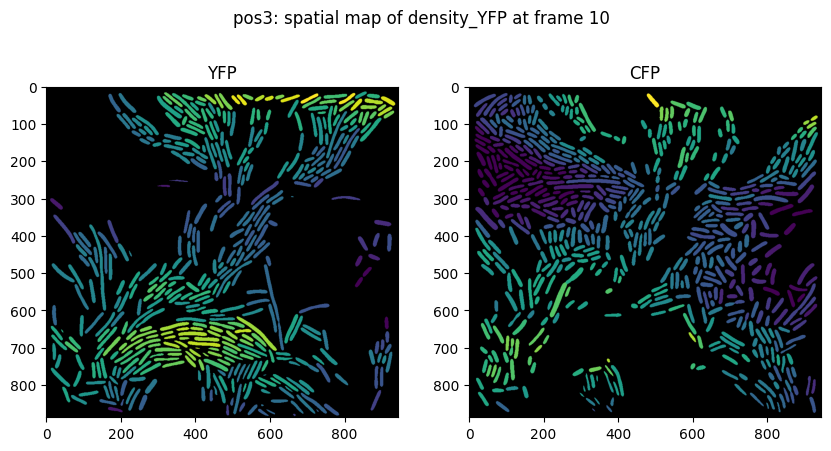

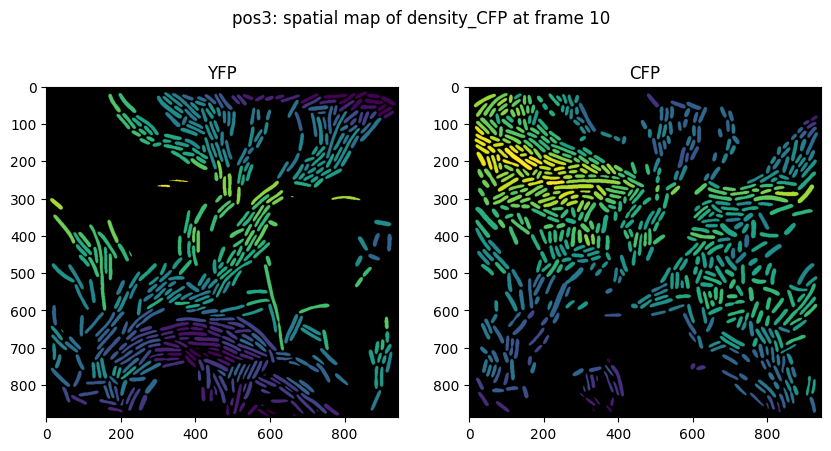

In [55]:
experiment.plot_spatial_maps(10,"density_YFP","pos3")
experiment.plot_spatial_maps(10,"density_CFP","pos3")

***

As we can see, we now created a density function that mainly calcualtes on horizontal density, but not vertical